# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.8 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


We define the neural network that will act as our Q function as follows

We take the 37 dimensional input state vector and feed it through a four layer network starting going from 128 nodes to 64, to 32 to 4 which is that dimensionality of the action space. We apply ReLU activation functions going into each layer and leave the output as logits as they are more numerically stable for optimization than applying a softmax to the output. 

In the event that the user provides their own sequence of layer sizes, then we incorportate those many layers with their respective sizes instead with ReLU's inbetween layers and logits as outputs. 

In [6]:
import torch
import torch.nn as nn

class QNetwork(nn.Module):
    """Actor Policy Model"""
    
    def __init__(self, state_size, action_size, seed, fc_units=[128, 64, 32]):
        """Initialize Parameters and setup model
        Parameters:
            state_size (int): Dimension of each state
            action_size (int): Dimensions of each action
            seed (int): Random seed
            fc_units (list[int]): list containing n elements corresponding to 
                    n hidden layers where each value corresponds to the 
                    number of hidden units in that layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.network = []
        last = state_size
        for units in fc_units:
            self.network.append(nn.Linear(last, units))
            self.network.append(nn.ReLU())
            last = units
        self.network.append(nn.Linear(last, action_size))
        
        self.network = nn.Sequential(*self.network)
        
    def forward(self, state):
        """Build the network that maps states to actions
        Parameters:
            state (batch tensor array[float]): state inputs to the network
        Return: the value of the action to take
        """
        return self.network(state)

Here we construct the agent that we are training with deep Q-learning using the QNetwork defined above to act as the Q function. We use two networks and a replay buffer to help ensure convergence as has been discovered in the literature. 

In [7]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5) # replay buffer size
BATCH_SIZE = 64        # minibatch size
GAMMA = 0.99           # discount factor
TAU = 1e-3             # to adjust soft update of target parameters
LR = 5e-4              # learning rate
UPDATE_EVERY = 4       # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the enviroment"""
    
    def __init__(self, state_size, action_size, seed):
        """
        Parameters:
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network
        self.qnetwork_active = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_active.parameters(), lr=LR)
        
        # Replay Memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done):
        # Save experiences to replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time step
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # Only replay if enough memories in buffer
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
                
    def action(self, state, eps=0.0):
        """Returns actions for given state as per current policy
        Parameters:
            state (numpy array[int]): current state vector
            eps (float): epsilon, for epsilon-greedy action selection
        """
        # convert input to tensor
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        # get action values from network for input state
        self.qnetwork_active.eval()
        with torch.no_grad():
            action_values = self.qnetwork_active(state)
        self.qnetwork_active.train()
        
        # epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from active model
        Q_expected = self.qnetwork_active(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        #  Update target network
        self.soft_update(self.qnetwork_active, self.qnetwork_target, TAU)
        
    def soft_update(self, active_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_active + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, active_param in zip(target_model.parameters(), active_model.parameters()):
            target_param.data.copy_(tau*active_param.data + (1.0-tau)*target_param.data)

The ReplayBuffer is where previous experiences and the actions that were taken with the respective next state and reward are stored and updated here. It has been shown that training on random batches from history help improve convergence by decorrelating recent states and actions beyond how much such a correlation is required. 

In [8]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples"""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer
        Parameters:
            action_size (int): dimensions of action
            buffer_size (int): maximum size of buffer
            batch_size (int): number of elements in each batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen = buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = seed
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

We create that enviroment that we train the passed in agent here to the specified goal as an average reward. 

We have set the average reward the agent should achieve for good performance in training to be 16.0 and then store a copy of the agents parameters in a file to be used later. 

In [9]:
def dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        
        score = 0
        for t in range(max_t):
            action = agent.action(state, eps)
            
            env_info = env.step(action)[brain_name]
            
            next_state = env_info.vector_observations[0]   
            reward = env_info.rewards[0]                   
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=16.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_active.state_dict(), 'checkpoint.pth')
            break
    return scores

We watch the agent train and plot the score vs episode once training has converged. 

In [10]:
agent = Agent(state_size, action_size, seed = 0)
scores = dqn(agent)

Episode 100	Average Score: 0.79
Episode 200	Average Score: 3.67
Episode 300	Average Score: 7.71
Episode 400	Average Score: 11.37
Episode 500	Average Score: 13.27
Episode 600	Average Score: 14.06
Episode 700	Average Score: 15.03
Episode 800	Average Score: 15.89
Episode 855	Average Score: 16.01
Environment solved in 855 episodes!	Average Score: 16.01


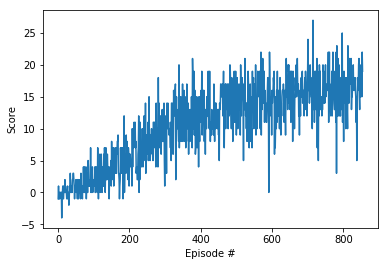

In [14]:
import matplotlib.pyplot as plt

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

We test the agent on the enviroment and see if it achieves a score of atleast 13.0 as our baseline for a good model in the enviroment. 

In [12]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                         # initialize the score
while True:
    action = agent.action(state)                   # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 15.0


When finished, we can close the environment.

In [13]:
env.close()